In [1]:
import json
import re
import pandas as pd
import numpy as np

def extract_predicted_holes(text):
    coord_pattern = re.compile(r'Hole\s+(\d+)\s+at\s+Position\s+\(([-\d.]+),\s*([-\d.]+),\s*([-\d.]+)\)')
    step_pattern = re.compile(r'Hole\s+(\d+)\s+Step\s+(\d+)\s+Length\s+([-\d.]+)')
    
    coords = {}
    steps = {}

    for match in coord_pattern.findall(text):
        hole_id = int(match[0])
        coords[hole_id] = tuple(map(float, match[1:]))

    for match in step_pattern.findall(text):
        hole_id = int(match[0])
        step_id = int(match[1])
        length = float(match[2])
        if hole_id not in steps:
            steps[hole_id] = {}
        steps[hole_id][step_id] = length

    return coords, steps

def process_jsonl_whole_hole(file_path, para32b=False):
    results = []
    fail_records = []
    source_file_to_pair_id = {}
    next_pair_id = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)

            source_file = data.get('metadata', {}).get('source_file', f'unknown_{next_pair_id}')
            if source_file not in source_file_to_pair_id:
                source_file_to_pair_id[source_file] = next_pair_id
                next_pair_id += 1
            pair_id = source_file_to_pair_id[source_file]

            masking_level = data.get("masking_level", None)
            successful = data.get("successful_generation", True)

            gt_list = data.get("ground_truth", [])
            gt_coords = {item['hole_id']: tuple(map(float, re.findall(r'[-\d.]+', item['coord']))) for item in gt_list}
            gt_steps = {
                item['hole_id']: {step['step']: float(step['length']) for step in item['step_lengths']}
                for item in gt_list
            }
            if para32b:
                gen_full = data.get("full_generated_output", "")
                gen_raw = gen_full.split("\n\n\n", 1)[-1].strip()
                gen_coords, gen_steps = extract_predicted_holes(gen_raw)    
            else:
                gen_output = data.get("full_generated_output", "")
                gen_coords, gen_steps = extract_predicted_holes(gen_output)            

            for hole_id in gt_coords:
                gt_coord = gt_coords[hole_id]
                gen_coord = gen_coords.get(hole_id)
                coord_missing = gen_coord is None
                coord_error = np.linalg.norm(np.array(gt_coord) - np.array(gen_coord)) if not coord_missing else None

                step_errors = []
                gen_step_data = gen_steps.get(hole_id, {})
                gt_step_data = gt_steps.get(hole_id, {})
                for step_id in gt_step_data:
                    gt_len = gt_step_data[step_id]
                    gen_len = gen_step_data.get(step_id)
                    if gen_len is not None:
                        step_errors.append(abs(gt_len - gen_len))
                    else:
                        step_errors.append(None)

                results.append({
                    'pair_id': pair_id,
                    'source_file': source_file,
                    'hole_id': hole_id,
                    'masking_level': masking_level,
                    'coord_error': coord_error,
                    'coord_missing': coord_missing,
                    'step_error_mean': np.nanmean([e for e in step_errors if e is not None]) if step_errors else None,
                    'step_missing_count': sum(1 for e in step_errors if e is None),
                    'step_total_count': len(gt_step_data)
                })

            if not successful:
                fail_records.append({
                    'pair_id': pair_id,
                    'source_file': source_file,
                    'masking_level': masking_level
                })

    df = pd.DataFrame(results)
    df_fail = pd.DataFrame(fail_records)
    return df, df_fail



C:\Users\kevin\AppData\Local\Temp\ipykernel_131624\3960612817.py:84: RuntimeWarning: Mean of empty slice
  'step_error_mean': np.nanmean([e for e in step_errors if e is not None]) if step_errors else None,


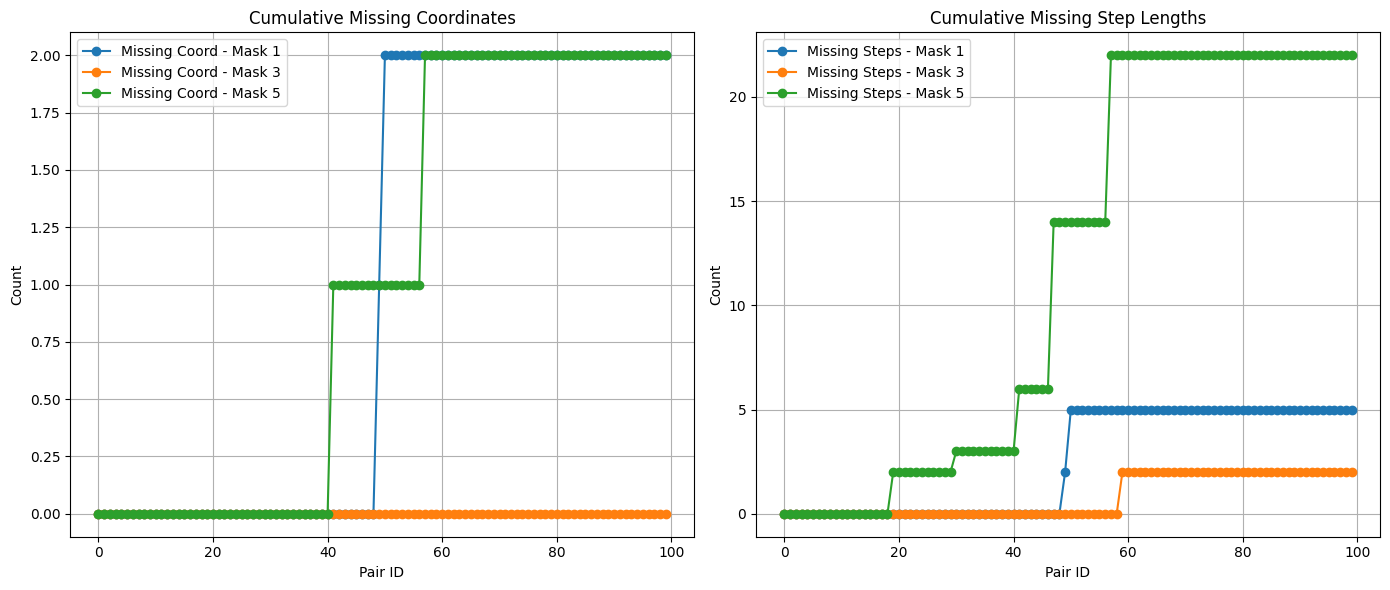

Masking Level 1:
  Mean Euclidean Error: 29.8989
  Mean Step Length Error: 12.8094
  Coord Regression Slope: 0.0046
  Step Regression Slope: -0.0175

Masking Level 3:
  Mean Euclidean Error: 39.8456
  Mean Step Length Error: 14.0149
  Coord Regression Slope: 0.0743
  Step Regression Slope: 0.0393

Masking Level 5:
  Mean Euclidean Error: 43.2660
  Mean Step Length Error: 15.9304
  Coord Regression Slope: 0.2031
  Step Regression Slope: -0.0209



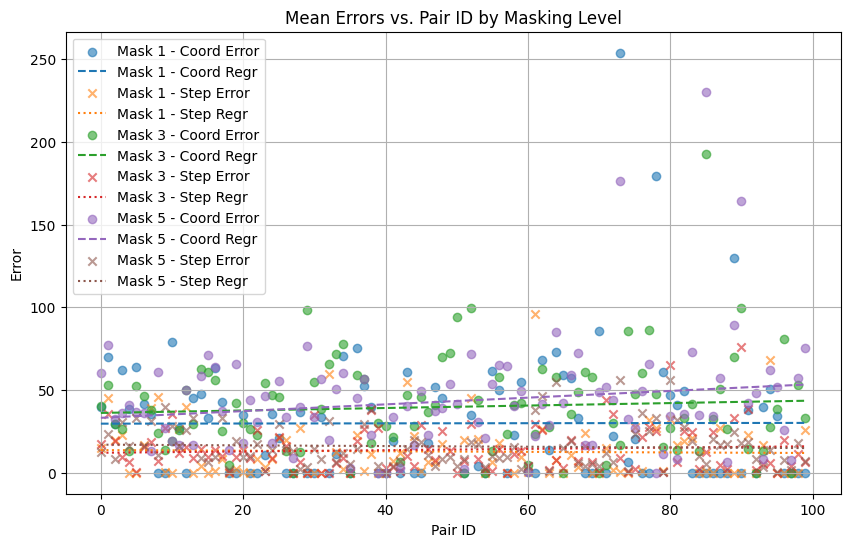

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def plot_whole_hole_metrics_with_step_error(df):
    df = df.copy()
    df.rename(columns={'coord_error': 'euclidean_error'}, inplace=True)

    masking_levels = sorted(df['masking_level'].dropna().unique())
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for level in masking_levels:
        df_level = df[df['masking_level'] == level]
        summary = df_level.groupby('pair_id').agg({
            'coord_missing': 'sum',
            'step_missing_count': 'sum'
        }).cumsum()

        ax1.plot(summary.index, summary['coord_missing'], label=f'Missing Coord - Mask {level}', marker='o')
        ax2.plot(summary.index, summary['step_missing_count'], label=f'Missing Steps - Mask {level}', marker='o')

    ax1.set_title('Cumulative Missing Coordinates')
    ax1.set_xlabel('Pair ID')
    ax1.set_ylabel('Count')
    ax1.grid(True)
    ax1.legend()

    ax2.set_title('Cumulative Missing Step Lengths')
    ax2.set_xlabel('Pair ID')
    ax2.set_ylabel('Count')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    for level in masking_levels:
        df_level = df[(df['masking_level'] == level) & df['euclidean_error'].notnull()]
        if not df_level.empty:
            mean_error_by_pair = df_level.groupby('pair_id')[['euclidean_error', 'step_error_mean']].mean()
            X = mean_error_by_pair.index.values.reshape(-1, 1)
            y_coord = mean_error_by_pair['euclidean_error'].values
            y_step = mean_error_by_pair['step_error_mean'].values

            model_coord = LinearRegression().fit(X, y_coord)
            model_step = LinearRegression().fit(X, y_step)

            plt.scatter(X, y_coord, label=f'Mask {level} - Coord Error', alpha=0.6)
            plt.plot(X, model_coord.predict(X), linestyle='--', label=f'Mask {level} - Coord Regr')

            plt.scatter(X, y_step, label=f'Mask {level} - Step Error', marker='x', alpha=0.6)
            plt.plot(X, model_step.predict(X), linestyle=':', label=f'Mask {level} - Step Regr')

            print(f"Masking Level {level}:")
            print(f"  Mean Euclidean Error: {np.nanmean(y_coord):.4f}")
            print(f"  Mean Step Length Error: {np.nanmean(y_step):.4f}")
            print(f"  Coord Regression Slope: {model_coord.coef_[0]:.4f}")
            print(f"  Step Regression Slope: {model_step.coef_[0]:.4f}\n")

    plt.xlabel('Pair ID')
    plt.ylabel('Error')
    plt.title('Mean Errors vs. Pair ID by Masking Level')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage:
df_whole, df_whole_fail = process_jsonl_whole_hole("aresults_whole.jsonl")
# Function is ready to use after file processing
plot_whole_hole_metrics_with_step_error(df_whole)

C:\Users\kevin\AppData\Local\Temp\ipykernel_131624\3960612817.py:84: RuntimeWarning: Mean of empty slice
  'step_error_mean': np.nanmean([e for e in step_errors if e is not None]) if step_errors else None,


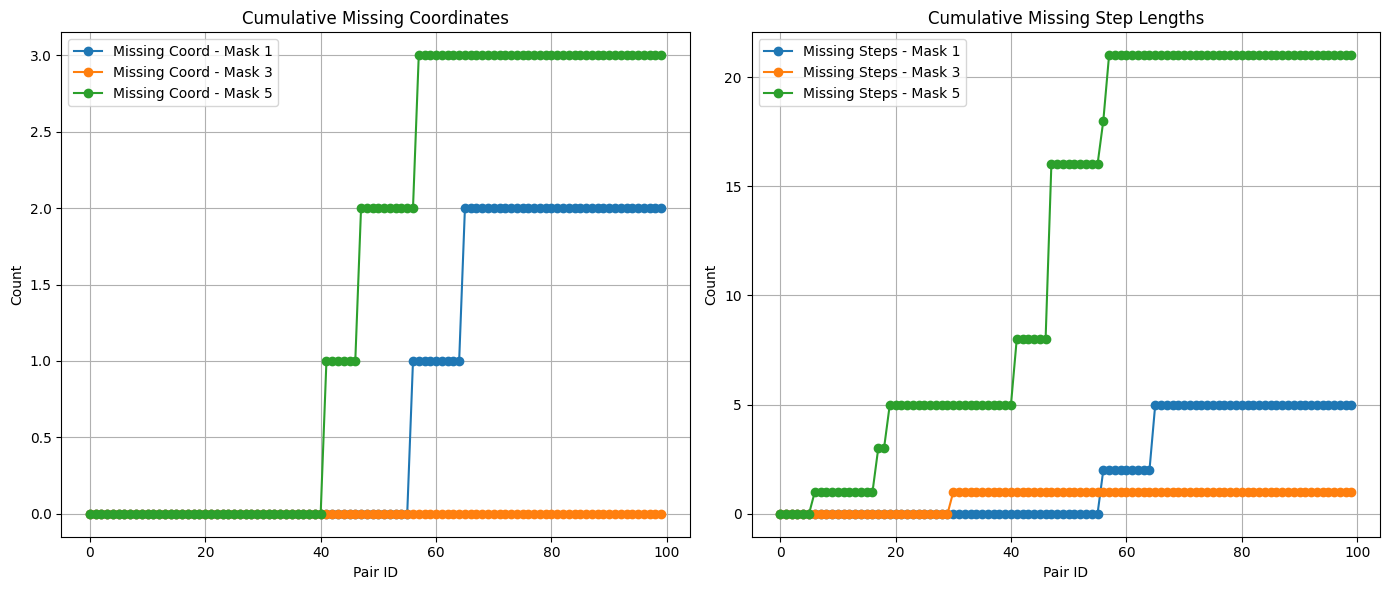

Masking Level 1:
  Mean Euclidean Error: 26.1153
  Mean Step Length Error: 13.7615
  Coord Regression Slope: -0.0226
  Step Regression Slope: -0.0376

Masking Level 3:
  Mean Euclidean Error: 36.8118
  Mean Step Length Error: 12.6354
  Coord Regression Slope: 0.1117
  Step Regression Slope: -0.0147

Masking Level 5:
  Mean Euclidean Error: 37.9660
  Mean Step Length Error: 14.9867
  Coord Regression Slope: 0.1374
  Step Regression Slope: -0.0332



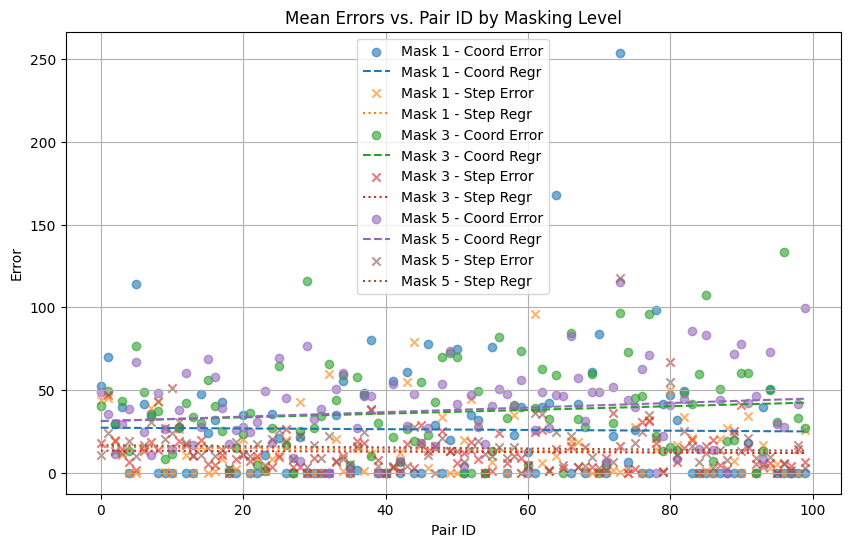

In [3]:
df_whole, df_whole_fail = process_jsonl_whole_hole("aresults_whole_32b.jsonl", para32b=True)
# Function is ready to use after file processing
plot_whole_hole_metrics_with_step_error(df_whole)

Example evaluation code loss based

In [4]:
def compute_relative_loss_increase(df_loss):
    # Filter to rows where both losses are not NaN and original_loss ≠ 0
    valid = df_loss.dropna(subset=["original_loss", "patched_loss"])
    valid = valid[valid["original_loss"] != 0]

    # Compute relative increase (%)
    relative_increase_pct = (
        (valid["patched_loss"] - valid["original_loss"]) / valid["original_loss"]
    ) * 100

    mean_increase = relative_increase_pct.mean()
    print(f"📈 Mean relative increase in patched loss over {len(valid)} files: {mean_increase:.2f}%")

    return mean_increase


In [5]:
import json
import re
import pandas as pd

def extract_predicted_holes(text):
    """Extract hole coordinates and step lengths from LLM's output."""
    coord_pattern = re.compile(r'Hole\s+(\d+)\s+at\s+Position\s+\(([-\d.]+),\s*([-\d.]+),\s*([-\d.]+)\)')
    step_pattern = re.compile(r'Hole\s+(\d+)\s+Step\s+(\d+)\s+Length\s+([-\d.]+)')

    coords = {}
    steps = {}

    for match in coord_pattern.findall(text):
        hole_id = int(match[0])
        coords[hole_id] = (float(match[1]), float(match[2]), float(match[3]))

    for match in step_pattern.findall(text):
        hole_id = int(match[0])
        step_id = int(match[1])
        length = float(match[2])
        steps.setdefault(hole_id, {})[step_id] = length

    return coords, steps

def process_masked_holes_only(file_path, para32b=False):
    results = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)

            source_file = data.get('metadata', {}).get('source_file', 'unknown')
            masking_level = data.get("masking_level", None)

            # Extract ground truth
            gt_list = data.get("ground_truth", [])
            gt_coords = {item['hole_id']: tuple(map(float, re.findall(r'[-\d.]+', item['coord']))) for item in gt_list}
            gt_steps = {
                item['hole_id']: {step['step']: float(step['length']) for step in item['step_lengths']}
                for item in gt_list
            }

            # Extract generated output (may be different for para32b)
            gen_output = data.get("full_generated_output", "")
            if para32b:
                gen_output = gen_output.split("\n\n\n", 1)[-1].strip()
            gen_coords, gen_steps = extract_predicted_holes(gen_output)

            for hole_id in gt_coords:
                row = {
                    "source_file": source_file,
                    "masking_level": masking_level,
                    "hole_id": hole_id,
                    "gt_coord": gt_coords[hole_id],
                    "gen_coord": gen_coords.get(hole_id),
                }

                # Step-level details
                gt_step_data = gt_steps.get(hole_id, {})
                gen_step_data = gen_steps.get(hole_id, {})

                for step_id in sorted(gt_step_data):
                    row_step = row.copy()
                    row_step.update({
                        "step_id": step_id,
                        "gt_step_length": gt_step_data.get(step_id),
                        "gen_step_length": gen_step_data.get(step_id),
                    })
                    results.append(row_step)

    df = pd.DataFrame(results)
    return df

import os
import requests
import xml.etree.ElementTree as ET
from collections import defaultdict
import pandas as pd

def evaluate_losses(df, xml_dir="manifolds", api_url="http://localhost:8080"):
    headers = {"Content-Type": "application/json"}
    results = []

    # Group predictions by source file and hole ID
    grouped = defaultdict(lambda: defaultdict(lambda: {"coord": None, "steps": {}}))
    for _, row in df.iterrows():
        sf = row['source_file']
        hid = int(row['hole_id'])
        sid = int(row['step_id'])

        if pd.notnull(row['gen_coord']):
            grouped[sf][hid]['coord'] = row['gen_coord']
        if pd.notnull(row['gen_step_length']):
            grouped[sf][hid]['steps'][sid] = row['gen_step_length']

    for source_file in grouped:
        xml_filename = source_file.replace(".txt", ".xml")
        xml_path = os.path.join(xml_dir, xml_filename)

        if not os.path.exists(xml_path):
            print(f"⚠️ File not found: {xml_path}")
            continue

        try:
            with open(xml_path, "r", encoding="utf-8") as f:
                original_xml = f.read()

            # Send original XML to get original loss
            init_data = {"command": "initialize", "xml_payload": original_xml}
            r1 = requests.post(api_url, headers=headers, json=init_data, timeout=10)
            user_id1 = r1.json().get("user_id") if r1.status_code == 200 else None
            cost1 = None
            if user_id1:
                r2 = requests.put(api_url, headers=headers, json={"command": "get_cost", "user_id": user_id1}, timeout=10)
                cost1 = r2.json().get("cost") if r2.status_code == 200 else None

            # Modify XML with predicted values
            tree = ET.ElementTree(ET.fromstring(original_xml))
            root = tree.getroot()

            holes = grouped[source_file]
            for pattern in root.findall(".//Pattern"):
                for hole in pattern.findall("./Holes/Hole"):
                    hole_id = int(hole.findtext("ID", "-1"))
                    if hole_id not in holes:
                        continue

                    mod = holes[hole_id]

                    # Update coordinates
                    if mod["coord"]:
                        pos_elem = hole.find("CurrentPosition")
                        pos_elem.find("X").text = f"{mod['coord'][0]:.3f}"
                        pos_elem.find("Y").text = f"{mod['coord'][1]:.3f}"
                        pos_elem.find("Z").text = f"{mod['coord'][2]:.3f}"

                    # Update step lengths
                    for step in hole.findall("./Steps/Step"):
                        step_number = int(step.findtext("StepNumber", "-1"))
                        if step_number in mod["steps"]:
                            step.find("Length").text = f"{mod['steps'][step_number]:.3f}"

            # Convert patched XML back to string
            patched_xml = ET.tostring(root, encoding="utf-8", method="xml").decode()

            # Send patched XML to get patched loss
            init_data = {"command": "initialize", "xml_payload": patched_xml}
            r1_p = requests.post(api_url, headers=headers, json=init_data, timeout=10)
            user_id2 = r1_p.json().get("user_id") if r1_p.status_code == 200 else None
            cost2 = None
            if user_id2:
                r2_p = requests.put(api_url, headers=headers, json={"command": "get_cost", "user_id": user_id2}, timeout=10)
                cost2 = r2_p.json().get("cost") if r2_p.status_code == 200 else None

            # Infer masking level from df
            file_df = df[df["source_file"] == source_file]
            inferred_masking_level = file_df["masking_level"].iloc[0] if not file_df.empty else None

            # Store results
            results.append({
                "filename": xml_filename,
                "original_loss": cost1,
                "patched_loss": cost2,
                "masking_level": inferred_masking_level
            })

         #   print(f"{xml_filename} | Original: {cost1} | Patched: {cost2}")

        except Exception as e:
           # print(f"❌ Error processing {xml_filename}: {e}")
            results.append({
                "filename": xml_filename,
                "original_loss": None,
                "patched_loss": None,
                "masking_level": None
            })

    return pd.DataFrame(results)



In [6]:
df = process_masked_holes_only('aresults_whole.jsonl', para32b=False)
df = df[df["masking_level"] == 1]
df_results = evaluate_losses(df, xml_dir="manifolds", api_url="http://localhost:8080")
print(df_results["original_loss"].isna().sum())
print(df_results["patched_loss"].isna().sum())
print(df_results["original_loss"].mean())
print(df_results["patched_loss"].mean())
print(compute_relative_loss_increase(df_results))
df = process_masked_holes_only('aresults_whole.jsonl', para32b=False)
df = df[df["masking_level"] == 3]
df_results = evaluate_losses(df, xml_dir="manifolds", api_url="http://localhost:8080")
print(df_results["original_loss"].isna().sum())
print(df_results["patched_loss"].isna().sum())
print(df_results["original_loss"].mean())
print(df_results["patched_loss"].mean())
print(compute_relative_loss_increase(df_results))
df = process_masked_holes_only('aresults_whole.jsonl', para32b=False)
df = df[df["masking_level"] == 5]
df_results = evaluate_losses(df, xml_dir="manifolds", api_url="http://localhost:8080")
print(df_results["original_loss"].isna().sum())
print(df_results["patched_loss"].isna().sum())
print(df_results["original_loss"].mean())
print(df_results["patched_loss"].mean())
print(compute_relative_loss_increase(df_results))

19
19
1.2200216790022387
1.594580327821952
📈 Mean relative increase in patched loss over 79 files: 55.02%
55.022491847423225
32
32
1.2238179837870546
2.8179252524073206
📈 Mean relative increase in patched loss over 68 files: 222.58%
222.58318940500115
55
55
1.1883638006642767
3.744786170651464
📈 Mean relative increase in patched loss over 45 files: 367.57%
367.57418743042484


Randomized baseline

In [7]:
import json
import re
import pandas as pd

def extract_predicted_holes(text):
    """Extract hole coordinates and step lengths from LLM's output."""
    coord_pattern = re.compile(r'Hole\s+(\d+)\s+at\s+Position\s+\(([-\d.]+),\s*([-\d.]+),\s*([-\d.]+)\)')
    step_pattern = re.compile(r'Hole\s+(\d+)\s+Step\s+(\d+)\s+Length\s+([-\d.]+)')

    coords = {}
    steps = {}

    for match in coord_pattern.findall(text):
        hole_id = int(match[0])
        coords[hole_id] = (float(match[1]), float(match[2]), float(match[3]))

    for match in step_pattern.findall(text):
        hole_id = int(match[0])
        step_id = int(match[1])
        length = float(match[2])
        steps.setdefault(hole_id, {})[step_id] = length

    return coords, steps

def extract_block_faces_and_hole_faces(input_text):
    """Extract block dimensions, face definitions, and hole-face assignments."""
    
    block_pattern = re.compile(r'Block Dimensions:\s*X:\s*([-\d.]+)\s*Y:\s*([-\d.]+)\s*Z:\s*([-\d.]+)', re.MULTILINE)
    face_pattern = re.compile(r'Face\s+(\d+):\s*Origin:\s*\(([-\d., ]+)\)\s*Inwards:\s*\(([-\d., ]+)\)', re.MULTILINE)
    hole_face_pattern = re.compile(r'Hole\s+(\d+)\s+\(Pattern\s+\d+,\s+Face\s+(\d+)\)')

    block_match = block_pattern.search(input_text)
    block_dims = tuple(map(float, block_match.groups())) if block_match else (None, None, None)

    faces = {}
    for match in face_pattern.finditer(input_text):
        face_id = int(match.group(1))
        origin = tuple(map(float, match.group(2).split(',')))
        inwards = tuple(map(float, match.group(3).split(',')))
        faces[face_id] = {"origin": origin, "inwards": inwards}

    hole_to_face = {}
    for match in hole_face_pattern.finditer(input_text):
        hole_id = int(match.group(1))
        face_id = int(match.group(2))
        hole_to_face[hole_id] = face_id

    return block_dims, faces, hole_to_face

def process_masked_holes_only(file_path, para32b=False):
    results = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)

            source_file = data.get('metadata', {}).get('source_file', 'unknown')
            masking_level = data.get("masking_level", None)
            input_text = data.get("input", "")

            block_dims, faces, hole_to_face = extract_block_faces_and_hole_faces(input_text)

            # Extract ground truth
            gt_list = data.get("ground_truth", [])
            gt_coords = {item['hole_id']: tuple(map(float, re.findall(r'[-\d.]+', item['coord']))) for item in gt_list}
            gt_steps = {
                item['hole_id']: {step['step']: float(step['length']) for step in item['step_lengths']}
                for item in gt_list
            }

            # Extract generated output (may be different for para32b)
            gen_output = data.get("full_generated_output", "")
            if para32b:
                gen_output = gen_output.split("\n\n\n", 1)[-1].strip()
            gen_coords, gen_steps = extract_predicted_holes(gen_output)

            for hole_id in gt_coords:
                face_id = hole_to_face.get(hole_id)
                face_data = faces.get(face_id, {"origin": (None, None, None), "inwards": (None, None, None)})

                row = {
                    "source_file": source_file,
                    "masking_level": masking_level,
                    "hole_id": hole_id,
                    "gt_coord": gt_coords[hole_id],
                    "gen_coord": gen_coords.get(hole_id),
                    "block_dim_x": block_dims[0],
                    "block_dim_y": block_dims[1],
                    "block_dim_z": block_dims[2],
                    "face_id": face_id,
                    "face_origin": face_data["origin"],
                    "face_inwards": face_data["inwards"],
                }

                # Step-level details
                gt_step_data = gt_steps.get(hole_id, {})
                gen_step_data = gen_steps.get(hole_id, {})

                for step_id in sorted(gt_step_data):
                    row_step = row.copy()
                    row_step.update({
                        "step_id": step_id,
                        "gt_step_length": gt_step_data.get(step_id),
                        "gen_step_length": gen_step_data.get(step_id),
                    })
                    results.append(row_step)

    df = pd.DataFrame(results)
    return df

import numpy as np

def replace_with_gamma_samples(df):
    """
    Replace all values in df['gen_step_length'] with samples from the specified Gamma distribution.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with 'gen_step_length' column.
    
    Returns:
    pd.DataFrame: DataFrame with 'gen_step_length' replaced.
    """
    shape = 0.8557185725841348
    loc = 0.0009999999999902376
    scale = 46.42952446442502

    num_samples = len(df)
    gamma_samples = np.random.gamma(shape, scale, size=num_samples) + loc

    df['gen_step_length'] = gamma_samples
    return df

import numpy as np

def randomize_coords_per_hole(df):
    """
    Replace gen_coord with a randomized coordinate for each unique (source_file, hole_id),
    respecting face orientation and block dimensions stored in the DataFrame.
    Same randomized coordinate applied to all rows of the same hole.
    """
    randomized_coords = {}

    for (source_file, hole_id), group in df.groupby(["source_file", "hole_id"]):
        row = group.iloc[0]

        gx, gy, gz = row["gt_coord"]
        ox, oy, oz = row["face_origin"]
        ix, iy, iz = row["face_inwards"]
        block_x = row["block_dim_x"]
        block_y = row["block_dim_y"]
        block_z = row["block_dim_z"]

        # Determine aligned axis based on inwards vector
        if np.isclose(abs(ix), 1.0):  # Face aligned along X
            x = ox
            y = np.random.uniform(0, block_y)
            z = np.random.uniform(0, block_z)
        elif np.isclose(abs(iy), 1.0):  # Face aligned along Y
            x = np.random.uniform(0, block_x)
            y = oy
            z = np.random.uniform(0, block_z)
        elif np.isclose(abs(iz), 1.0):  # Face aligned along Z
            x = np.random.uniform(0, block_x)
            y = np.random.uniform(0, block_y)
            z = oz
        else:
            # Alignment unclear; assign NaN to mark as invalid
            x, y, z = np.nan, np.nan, np.nan

        randomized_coords[(source_file, hole_id)] = (x, y, z)

    # Apply consistent randomized coords to all rows
    df["gen_coord"] = df.apply(
        lambda row: randomized_coords.get((row["source_file"], row["hole_id"])), axis=1
    )

    return df


In [ ]:

import os
import requests
import xml.etree.ElementTree as ET
from collections import defaultdict
import pandas as pd

def evaluate_losses(df, xml_dir="manifolds", api_url="http://localhost:8080"):
    headers = {"Content-Type": "application/json"}
    results = []

    # Group predictions by source file and hole ID
    grouped = defaultdict(lambda: defaultdict(lambda: {"coord": None, "steps": {}}))
    for _, row in df.iterrows():
        sf = row['source_file']
        hid = int(row['hole_id'])
        sid = int(row['step_id'])

        if pd.notnull(row['gen_coord']):
            grouped[sf][hid]['coord'] = row['gen_coord']
        if pd.notnull(row['gen_step_length']):
            grouped[sf][hid]['steps'][sid] = row['gen_step_length']

    for source_file in grouped:
        xml_filename = source_file.replace(".txt", ".xml")
        xml_path = os.path.join(xml_dir, xml_filename)

        if not os.path.exists(xml_path):
            print(f"⚠️ File not found: {xml_path}")
            continue

        try:
            with open(xml_path, "r", encoding="utf-8") as f:
                original_xml = f.read()

            # Send original XML to get original loss
            init_data = {"command": "initialize", "xml_payload": original_xml}
            r1 = requests.post(api_url, headers=headers, json=init_data, timeout=10)
            user_id1 = r1.json().get("user_id") if r1.status_code == 200 else None
            cost1 = None
            if user_id1:
                r2 = requests.put(api_url, headers=headers, json={"command": "get_cost", "user_id": user_id1}, timeout=10)
                cost1 = r2.json().get("cost") if r2.status_code == 200 else None

            # Modify XML with predicted values
            tree = ET.ElementTree(ET.fromstring(original_xml))
            root = tree.getroot()

            holes = grouped[source_file]
            for pattern in root.findall(".//Pattern"):
                for hole in pattern.findall("./Holes/Hole"):
                    hole_id = int(hole.findtext("ID", "-1"))
                    if hole_id not in holes:
                        continue

                    mod = holes[hole_id]

                    # Update coordinates
                    if mod["coord"]:
                        pos_elem = hole.find("CurrentPosition")
                        pos_elem.find("X").text = f"{mod['coord'][0]:.3f}"
                        pos_elem.find("Y").text = f"{mod['coord'][1]:.3f}"
                        pos_elem.find("Z").text = f"{mod['coord'][2]:.3f}"

                    # Update step lengths
                    for step in hole.findall("./Steps/Step"):
                        step_number = int(step.findtext("StepNumber", "-1"))
                        if step_number in mod["steps"]:
                            step.find("Length").text = f"{mod['steps'][step_number]:.3f}"

            # Convert patched XML back to string
            patched_xml = ET.tostring(root, encoding="utf-8", method="xml").decode()

            # Send patched XML to get patched loss
            init_data = {"command": "initialize", "xml_payload": patched_xml}
            r1_p = requests.post(api_url, headers=headers, json=init_data, timeout=10)
            user_id2 = r1_p.json().get("user_id") if r1_p.status_code == 200 else None
            cost2 = None
            if user_id2:
                r2_p = requests.put(api_url, headers=headers, json={"command": "get_cost", "user_id": user_id2}, timeout=10)
                cost2 = r2_p.json().get("cost") if r2_p.status_code == 200 else None

            # Infer masking level from df
            file_df = df[df["source_file"] == source_file]
            inferred_masking_level = file_df["masking_level"].iloc[0] if not file_df.empty else None
            # If cost1 or cost2 is None, we assume no loss was computed
            # Store results
            results.append({
                "filename": xml_filename,
                "original_loss": cost1,
                "patched_loss": cost2,
                "masking_level": inferred_masking_level
            })

         #   print(f"{xml_filename} | Original: {cost1} | Patched: {cost2}")

        except Exception as e:
           # print(f"❌ Error processing {xml_filename}: {e}")
            results.append({
                "filename": xml_filename,
                "original_loss": None,
                "patched_loss": None,
                "masking_level": None
            })

    return pd.DataFrame(results)



In [13]:
df = process_masked_holes_only('aresults_whole.jsonl', para32b=False)
df = randomize_coords_per_hole(df)
df = replace_with_gamma_samples(df)
df = df[df["masking_level"] == 1]
df_results = evaluate_losses(df, xml_dir="manifolds", api_url="http://localhost:8080")
print(df_results["original_loss"].isna().sum())
print(df_results["patched_loss"].isna().sum())
print(df_results["original_loss"].mean())
print(df_results["patched_loss"].mean())
print(compute_relative_loss_increase(df_results))
df = process_masked_holes_only('aresults_whole.jsonl', para32b=False)
df = randomize_coords_per_hole(df)
df = replace_with_gamma_samples(df)
df = df[df["masking_level"] == 3]
df_results = evaluate_losses(df, xml_dir="manifolds", api_url="http://localhost:8080")
print(df_results["original_loss"].isna().sum())
print(df_results["patched_loss"].isna().sum())
print(df_results["original_loss"].mean())
print(df_results["patched_loss"].mean())
print(compute_relative_loss_increase(df_results))
df = process_masked_holes_only('aresults_whole.jsonl', para32b=False)
df = randomize_coords_per_hole(df)
df = replace_with_gamma_samples(df)
df = df[df["masking_level"] == 5]
df_results = evaluate_losses(df, xml_dir="manifolds", api_url="http://localhost:8080")
print(df_results["original_loss"].isna().sum())
print(df_results["patched_loss"].isna().sum())
print(df_results["original_loss"].mean())
print(df_results["patched_loss"].mean())
print(compute_relative_loss_increase(df_results))

14
14
1.179584486366737
1.548298143744789
📈 Mean relative increase in patched loss over 86 files: 49.16%
49.16322275749107
14
14
1.2153343068426508
2.0087924817379843
📈 Mean relative increase in patched loss over 86 files: 121.88%
121.8764470037999
14
14
1.1719444762080802
2.3552300066314014
📈 Mean relative increase in patched loss over 86 files: 200.78%
200.78142758781016
